<a href="https://colab.research.google.com/github/adammoss/bnn_hmc/blob/main/results/CMD_ensemble.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import sys
import shutil
import subprocess
import glob
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
nruns = 10

In [3]:
!nvidia-smi

Thu Aug 18 08:59:18 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    24W / 300W |      0MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
!pip install astro-datasets --upgrade
!pip install tensorflow_datasets --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for astro-datasets: filename=astro_datasets-0.0.10-py3-none-any.whl size=15992 sha256=19135879e275bf96d4ba6a25e3cd3f46662e76dddca60770e2c3e94903adedce
  Stored in directory: /root/.cache/pip/wheels/33/b2/9d/97c264f6addbd178fe1c8ff119617e1515cb8c0d0f220605cf
Successfully built astro-datasets
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
shutil.rmtree('bnn_hmc', ignore_errors=True)

In [6]:
!git clone https://github.com/adammoss/bnn_hmc

Cloning into 'bnn_hmc'...
remote: Enumerating objects: 324, done.
remote: Counting objects: 100% (36/36), done.
remote: Compressing objects: 100% (28/28), done.
remote: Total 324 (delta 17), reused 15 (delta 8), pack-reused 288
Receiving objects: 100% (324/324), 770.89 KiB | 16.06 MiB/s, done.
Resolving deltas: 100% (211/211), done.


In [7]:
# https://storage.googleapis.com/jax-releases/jax_cuda_releases.html
!pip install --upgrade https://storage.googleapis.com/jax-releases/cuda111/jaxlib-0.1.65+cuda111-cp37-none-manylinux2010_x86_64.whl
!pip install jax==0.2.12
!pip install dm-haiku==0.0.5.dev0 optax==0.0.6 chex==0.0.6

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 189.4 MB 17 kB/s 
  Attempting uninstall: jaxlib
    Found existing installation: jaxlib 0.3.14+cuda11.cudnn805
    Uninstalling jaxlib-0.3.14+cuda11.cudnn805:
      Successfully uninstalled jaxlib-0.3.14+cuda11.cudnn805
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 590 kB 17.1 MB/s 
  Created wheel for jax: filename=jax-0.2.12-py3-none-any.whl size=682487 sha256=40a03db418fa60675a9a433463b53298a3a9fc5c791285976cbfd828103bfaf6
  Stored in directory: /root/.cache/pip/wheels/f6/4d/e5/73eec5070b77f25664c67bd793d4eb97f41bbf9be7afafd15e
Successfully built jax
  Attempting uninstall: jax
    Found existing installation: jax 0.3.14
    Uninstalling jax-0.3.14:
      Successfully uninstalled jax-0.3.14
Looking in indexes: https://pypi.org/simple, https://us-python.p

In [8]:
for i, root in enumerate(glob.glob('/content/runs/*/')):
  shutil.rmtree(root, ignore_errors=True)

In [9]:
for i in range(nruns):
 base_cmd = ['python3', 'bnn_hmc/scripts/run_sgd.py', '--seed=%s' % i, '--weight_decay=10', '--dir=runs/sgd/cmd/resnet/%s/' % i, 
 '--dataset_name=cmd', '--model_name=resnet20_frn_swish', '--scaling=asinh', 
 '--init_step_size=1e-7', '--num_epochs=50', '--save_freq=5',
 '--builder_kwargs={"simulation": "IllustrisTNG", "field": "Mtot", "parameters": ["omegam"]}',
 '--image_size=64', '--eval_freq=5', '--batch_size=100', '--optimizer=SGD']
 train_cmd = base_cmd + ['--train_split=train[:90%]', '--test_split=train[90%:95%]']
 eval_cmd = base_cmd + ['--eval_split=train[95%:]']
 print(' '.join(train_cmd))
 p = subprocess.run(train_cmd, capture_output=True)
 print(p.stdout.decode('utf8'))
 p = subprocess.run(eval_cmd, capture_output=True)
 print(p.stdout.decode('utf8'))

python3 bnn_hmc/scripts/run_sgd.py --seed=0 --weight_decay=10 --dir=runs/sgd/cmd/resnet/0/ --dataset_name=cmd --model_name=resnet20_frn_swish --scaling=asinh --init_step_size=1e-7 --num_epochs=50 --save_freq=5 --builder_kwargs={"simulation": "IllustrisTNG", "field": "Mtot", "parameters": ["omegam"]} --image_size=64 --eval_freq=5 --batch_size=100 --optimizer=SGD --train_split=train[:90%] --test_split=train[90%:95%]
JAX sees the following devices: [GpuDevice(id=0, process_index=0)]
TF sees the following devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]
Dataset cmd downloaded and prepared to /root/tensorflow_datasets/IllustrisTNG_Mtot_omegam/cmd/1.0.3. Subsequent calls will reuse this data.
Starting from random initialization with provided seed
---  --------  ------------  -----------  -----------  ----------  ---------------  --------------  --------
  i         t    train/rmse    train/nll    test/rmse    test/nll  test/ens_rmse    test/ens_nll          lr
--- 

In [22]:
predictions = []
errors = []
for i, root in enumerate(glob.glob('/content/runs/sgd/cmd/resnet/*/*/')):
  metrics = np.load(root + '/metrics.npy', allow_pickle=True)
  if metrics.item()['scaled_mse'] > 1:
    # Do not include any runs which have diverged
    continue
  data = np.load(root + '/test_set.npy')  
  prediction = np.load(root + '/predictions.npy')
  predictions.append(prediction[0,:,0])
  errors.append(prediction[0,:,1])
  print(metrics)
predictions = np.array(predictions)
errors = np.array(errors)

{'scaled_nll': array(-1.694503, dtype=float32), 'scaled_mse': array(0.00238634, dtype=float32), 'scaled_rmse': 0.04885013, 'nll': array(-1.694503, dtype=float32), 'mse': array(0.00238634, dtype=float32), 'rmse': 0.04885013}
{'scaled_nll': array(-1.5706539, dtype=float32), 'scaled_mse': array(0.00272563, dtype=float32), 'scaled_rmse': 0.052207597, 'nll': array(-1.5706539, dtype=float32), 'mse': array(0.00272563, dtype=float32), 'rmse': 0.052207597}
{'scaled_nll': array(-1.6774734, dtype=float32), 'scaled_mse': array(0.00234988, dtype=float32), 'scaled_rmse': 0.04847553, 'nll': array(-1.6774734, dtype=float32), 'mse': array(0.00234988, dtype=float32), 'rmse': 0.04847553}
{'scaled_nll': array(-0.1802522, dtype=float32), 'scaled_mse': array(0.0041221, dtype=float32), 'scaled_rmse': 0.064203575, 'nll': array(-0.1802522, dtype=float32), 'mse': array(0.0041221, dtype=float32), 'rmse': 0.064203575}
{'scaled_nll': array(-1.6837863, dtype=float32), 'scaled_mse': array(0.00237295, dtype=float32),

In [23]:
mean_predictions = np.mean(predictions, axis=0)
mean_errors = np.mean(errors, axis=0)
total_errors = (mean_errors**2 + np.std(predictions, axis=0)**2)**0.5
diffs = mean_predictions - data[0,:,0]

In [24]:
print('Ensemble MSE', np.mean(diffs**2))
print('Ensemble MAE', np.mean(np.abs(diffs)))

Ensemble MSE 0.002259215
Ensemble MAE 0.03752418


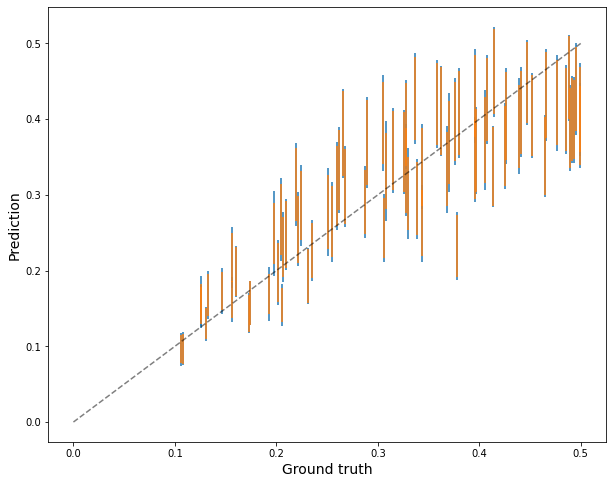

In [32]:
plt.figure(figsize=(10,8))
plt.errorbar(data[0,::10,0], mean_predictions[::10], total_errors[::10],  ls='none')
plt.errorbar(data[0,::10,0], mean_predictions[::10], mean_errors[::10],  ls='none')
plt.plot(np.linspace(0,0.5,10), np.linspace(0,0.5,10), linestyle='--', color='black', alpha=0.5)
plt.xlabel('Ground truth', fontsize=14)
plt.ylabel('Prediction', fontsize=14)
plt.show()